# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/TX

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/TX


In [ ]:
!pip install ultralytics

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
import seaborn as sns
import glob
from tqdm import tqdm

import torch
from torch.nn import functional as F
from skimage import transform, measure
from PIL import Image
from ultralytics import YOLO

# Functions

In [ ]:
# Function to find and load alll BMP into an array
def load_images_to_array_input(folder_path, categories):
"""
    Load all BMP images from the specified folders into a NumPy array.

    This function searches for directories within the given `folder_path` that match
    a specific naming convention ("Crop_Pics_w_parameters_" and "mbar"). It then
    recursively searches for all BMP images within these identified folders and
    their subdirectories, loading them into a list of NumPy arrays. Each image is
    also associated with a numerical label based on its category and its original
    file path.

    Args:
        folder_path (str): The absolute or relative path to the root folder where
                           image categories are located. This is the starting point
                           for searching for relevant subfolders.
        categories (list): A list of strings, where each string is a category name
                           (expected to be a subfolder within the `base_folders`).
                           Images found in these subfolders will be assigned a label
                           corresponding to their category's index in this list.

    Returns:
        tuple: A tuple containing three lists:
            - images (list): A list of loaded images, where each image is a NumPy
                             array (converted from BGR to RGB format).
            - labels (list): A list of integer labels, where each label corresponds
                             to the category of the respective image. The index of
                             the category in the `categories` list determines the label.
            - paths (list): A list of strings, where each string is the full file
                            path to the original BMP image.
    """

    images = []
    labels = []
    paths = []

    category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

    base_folders = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and "Crop_Pics_w_parameters_" in item and "mbar" in item:
            base_folders.append(item_path)

    if not base_folders:
        print("No folder found in correct format.")
        return images, labels, paths

    print(f"Found {len(base_folders)} folders:")
    for folder in base_folders:
        print(f"- {os.path.basename(folder)}")

    for base_folder in base_folders:
        print(f"Scanning the folder: {os.path.basename(base_folder)}")

        for category in categories:
            category_path = os.path.join(base_folder, category)

            if os.path.isdir(category_path):
                print(f"Found category: {category}")

                bmp_files = glob.glob(os.path.join(category_path, '**', '*.bmp'), recursive=True)

                for bmp_file in tqdm(bmp_files, desc=f"Loading {category}"):
                    img = cv2.imread(bmp_file)

                    if img is not None:
                        # Convert from BGR to RGB
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        images.append(img_rgb)
                        labels.append(category_to_idx[category])
                        paths.append(bmp_file)

    print(f"Completed! Loaded {len(images)} images in total.")

    for category, idx in category_to_idx.items():
        count = labels.count(idx)
        print(f"  - {category}: {count} images")

    return images, labels, paths

def load_images_to_array(folder_path, categories):
    """
    Load all BMP images from specified category subfolders within a given root folder
    into a NumPy array.

    This function directly looks for subfolders named after the provided categories
    within the `folder_path`. It then recursively finds and loads all BMP images
    from these category-specific subfolders, converting them to RGB format.

    Args:
        folder_path (str): The path to the root folder that contains the category
                           subfolders (e.g., 'category_A', 'category_B').
        categories (list): A list of strings, where each string is a category name
                           corresponding to a subfolder within `folder_path`.

    Returns:
        tuple: A tuple containing three lists:
            - images (list): A list of loaded images, where each image is a NumPy
                             array (converted from BGR to RGB format).
            - labels (list): A list of integer labels, where each label corresponds
                             to the category of the respective image. The index of
                             the category name in the `categories` list determines the label.
            - paths (list): A list of strings, where each string is the full file
                            path to the original BMP image.
    """

    images = []
    labels = []
    paths = []

    category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

    if not os.path.exists(folder_path):
        print(f"ERROR: {folder_path} don't exist!")
        return images, labels, paths

    print(f"Folder: {folder_path}")

    print("Searching images")
    for category in categories:
        category_path = os.path.join(folder_path, category)

        if os.path.isdir(category_path):
            print(f"Found category: {category}")

            bmp_files = glob.glob(os.path.join(category_path, '**', '*.bmp'), recursive=True)

            for bmp_file in tqdm(bmp_files, desc=f"Loading {category}"):
                img = cv2.imread(bmp_file)

                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    images.append(img_rgb)
                    labels.append(category_to_idx[category])
                    paths.append(bmp_file)

    print(f"Completed! Loaded {len(images)} images in total.")

    for category, idx in category_to_idx.items():
        count = labels.count(idx)
        print(f"  - {category}: {count} images")

    return images, labels, paths

# Function to visualize images
def show_sample_images(images, labels, categories, num_samples=5):
    """
    Display a grid of sample images, organized by category.

    This function creates subplots to show a small number of images from each
    specified category, providing a quick visual overview of the dataset.

    Args:
        images (list): A list of NumPy arrays, where each array represents an image.
        labels (list): A list of integer labels, where each label corresponds to
                       the category of the respective image in the `images` list.
        categories (list): A list of strings, where each string is the name
                           of a category, corresponding to the integer labels.
        num_samples (int, optional): The maximum number of sample images to display
                                     for each category. Defaults to 5.
    """

    if not images:
        print("No images to visualized")
        return

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 3*len(categories)))

    for cat_idx, category in enumerate(categories):
        cat_indices = [i for i, label in enumerate(labels) if label == cat_idx]

        samples = min(num_samples, len(cat_indices))

        for sample_idx in range(samples):
            if len(categories) > 1:
                ax = axes[cat_idx, sample_idx]
            else:
                ax = axes[sample_idx]

            img_idx = cat_indices[sample_idx]

            ax.imshow(images[img_idx])
            ax.set_title(f"{category}")
            ax.axis('off')

        for j in range(samples, num_samples):
            if len(categories) > 1:
                axes[cat_idx, j].axis('off')
            else:
                axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Function to convert list into NumPy
def convert_to_numpy_arrays(images, labels):
    """
    Converts lists of image NumPy arrays and their corresponding labels into
    single, stacked NumPy arrays (X for images, y for labels).

    This function also includes logic to detect if images have different
    dimensions and, if so, resizes them to a common size (the most common
    height and width found) to allow stacking into a single NumPy array.

    Args:
        images (list): A list of NumPy arrays, where each array represents an image.
        labels (list): A list of integers or strings representing the labels
                       for each image.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - X (np.array): A stacked NumPy array containing all images. If images
                            had different sizes, they are resized to a common
                            dimension before stacking. Shape will be (num_images, H, W, C).
            - y (np.array): A NumPy array containing all labels.
    """

    if images:
        heights = [img.shape[0] for img in images]
        widths = [img.shape[1] for img in images]
        channels = [img.shape[2] for img in images]

        if len(set(heights)) > 1 or len(set(widths)) > 1 or len(set(channels)) > 1:
            print("WARNING: Images have different sizes!")
            print(f"Height: {set(heights)}")
            print(f"Width: {set(widths)}")
            print(f"Channel: {set(channels)}")

            from collections import Counter
            common_height = 100 #Counter(heights).most_common(1)[0][0]
            common_width = 200 #Counter(widths).most_common(1)[0][0]
            common_channels = Counter(channels).most_common(1)[0][0]

            print(f"Resizing all images to {common_height}x{common_width}x{common_channels}")

            resized_images = []
            for img in tqdm(images, desc="Image resizing"):
                if img.shape != (common_height, common_width, common_channels):
                    resized = cv2.resize(img, (common_width, common_height))
                    resized_images.append(resized)
                else:
                    resized_images.append(img)

            X = np.stack(resized_images, axis=0)
        else:
            X = np.stack(images, axis=0)
    else:
        X = np.array([])

    y = np.array(labels)

    return X, y


In [ ]:
def detect_images(images, model):
    """
    Detects objects (e.g., cells) in a list of images using a given model
    and extracts their bounding box coordinates.

    Args:
        images (list): A list of images, which can be in various formats
                       acceptable by the model's prediction method (e.g., NumPy arrays, PIL Images).
        model: The trained object detection model (e.g., a YOLO model) with a
               `predict` or call method that returns detection results.

    Returns:
        list: A list of lists, where each inner list contains the bounding box
              coordinates (center_x, center_y, width, height) for all detected
              objects in the corresponding input image.
    """
    all_xywh = []  # better name

    for img in images:
        results = model(img)  # predict on an image

        img_xywh = []  # store masks for *this* image

        for result in results:
            xywh = result.boxes.xywh  # center-x, center-y, width, height
            img_xywh.append(xywh)  # add to list for this image

        all_xywh.append(img_xywh)  # add this image's masks to the big list

    return all_xywh

def crop_from_bboxes(images, all_bboxes, margin=10):
    """
    Crops regions from images based on provided bounding boxes, adding an optional margin.
    It also collects metadata for each cropped region (e.g., cell).

    Args:
        images (list of PIL Images or Tensors): List of original images. Images will be
                                                converted to PyTorch Tensors if they are PIL Images.
                                                Expected format is (H, W, C) for PIL or (C, H, W) for Tensor.
        all_bboxes (list of list of Tensors): A list where each inner list contains
                                              PyTorch Tensors of bounding box coordinates for
                                              a corresponding image. Each bbox Tensor is expected
                                              to be in [x1, y1, x2, y2] format.
        margin (int, optional): The number of pixels to add as a margin around each
                                bounding box before cropping. Defaults to 10.

    Returns:
        tuple: A tuple containing:
            - cropped_images (list of list of Tensors): A list where each inner list
                                                       contains PyTorch Tensors of the
                                                       cropped images corresponding to the
                                                       original image's detected objects.
            - cell_metadata (list of dicts): A list of dictionaries, where each dictionary
                                             contains metadata for a single cropped region,
                                             including its original image index, cell index,
                                             center coordinates, bounding box (with margin),
                                             height, and width.
    """
    cropped_images = []
    cell_metadata = []

    for img_idx, (img, bboxes_list) in enumerate(zip(images, all_bboxes)):
        img_crops = []

        # If image is PIL, convert to tensor
        if not torch.is_tensor(img):
            img = TF.to_tensor(img)

        _, H, W = img.shape  # C, H, W

        bbox_idx = 0  # Reset bbox_idx per image

        for bbox_tensor in bboxes_list:
            if bbox_tensor.ndim == 1:
                bbox_tensor = bbox_tensor.unsqueeze(0)

            for bbox in bbox_tensor:
                x1, y1, x2, y2 = bbox.tolist()

                # Add margin and clip
                x_min = max(int(x1) - margin, 0)
                y_min = max(int(y1) - margin, 0)
                x_max = min(int(x2) + margin, W)
                y_max = min(int(y2) + margin, H)

                # Ensure valid crop dimensions (non-zero area)
                if x_max > x_min and y_max > y_min:
                    crop = img[:, y_min:y_max, x_min:x_max]  # [C, H_crop, W_crop]
                    img_crops.append(crop)

                    # Compute center
                    cx = (x_min + x_max) / 2
                    cy = (y_min + y_max) / 2

                    # Add metadata
                    cell_metadata.append({
                        'original_image_idx': img_idx,
                        'cell_idx': bbox_idx,
                        'center': (cx, cy),
                        'bbox': (x_min, y_min, x_max, y_max),
                        'height': y_max - y_min,
                        'width': x_max - x_min,
                    })
                else:
                    print(f"Skipping invalid crop for bbox {bbox} in image {img_idx}")

                bbox_idx += 1  # Increment bbox index for this image

        cropped_images.append(img_crops)

    return cropped_images, cell_metadata


def visualize_results(images, cropped_cells, cell_metadata, ncols=2):
    """
    Visualizes original images and their corresponding cropped cells side by side.
    Each row of the plot represents an original image, showing the original
    image and all the cells cropped from it.

    Args:
        images (list of PIL Images or Tensors): List of original input images.
                                                Expected to be in (C, H, W) format if Tensor.
        cropped_cells (list of list of Tensors): A list where each inner list contains
                                                PyTorch Tensors of the cropped cells
                                                for a corresponding original image.
        cell_metadata (list of dicts): A list of dictionaries, where each dictionary
                                       contains metadata for a single cropped cell.
                                       Used to provide context (e.g., crop index).
        ncols (int, optional): The number of columns in the output plot grid.
                               Defaults to 2 (one for original, one for crops).
    """
    # Calculate number of rows for the plot grid
    nrows = len(images)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))

    # Handle case where there's only one row or column
    if nrows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [axes]

    # Loop through each image and its corresponding cropped cells
    for i, (img, crops) in enumerate(zip(images, cropped_cells)):
        # Plot original image
        ax = axes[i][0] if ncols > 1 else axes[i]
        ax.imshow(TF.to_pil_image(img))
        ax.set_title(f"Original Image {i+1}")
        ax.axis('off')

        # Plot each cropped image for this original image
        for j, crop in enumerate(crops):
            ax = axes[i][1] if ncols > 1 else axes[i]  # Only one column for single image case
            ax.imshow(TF.to_pil_image(crop))
            ax.set_title(f"Crop {j+1} of Image {i+1}")
            ax.axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

def save_cropped_cells(cropped_cells, output_dir, original_labels=None, cell_metadata=None):
    """
    Save the extracted and cropped cells as image files to a specified directory.
    Images are saved as PNGs and can be organized into subdirectories based on their
    original labels if provided. The filename includes metadata for easy identification.

    Args:
        cropped_cells_per_original_image (list of list of Tensors): A list where each inner list
                                                                     contains PyTorch Tensors of
                                                                     cropped cells from an original image.
        output_dir (str): The path to the root directory where the cropped cells will be saved.
        original_labels (list, optional): A list of integer labels for the original images.
                                         If provided, cropped cells will be saved into
                                         'class_X' subdirectories based on the original image's label.
                                         Defaults to None.
        cell_metadata (list of dicts, optional): A list of dictionaries, where each dictionary
                                                 contains metadata for a single cropped cell.
                                                 This is used to link cropped cells back to their
                                                 original images and to include details like cell_idx
                                                 and radius in the filename. Defaults to None.
    """
    if len(cropped_cells) == 0:
        print("No cropped cells to save.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for each category if labels are provided
    if original_labels is not None:
        label_dirs = {}
        unique_labels = np.unique(original_labels)
        for label in unique_labels:
            label_dir = os.path.join(output_dir, f"class_{label}")
            os.makedirs(label_dir, exist_ok=True)
            label_dirs[label] = label_dir

    # Save each cropped cell
    for i, cell_img in enumerate(cropped_cells):
        if cell_metadata and i < len(cell_metadata):
            metadata = cell_metadata[i]
            original_idx = metadata['original_image_idx']
            radius = metadata['radius']

            # Determine the label for this cell
            if original_labels is not None and original_idx < len(original_labels):
                label = original_labels[original_idx]
                save_path = os.path.join(label_dirs[label], f"cell_{original_idx}_{metadata['cell_idx']}_r{int(radius)}.png")
            else:
                save_path = os.path.join(output_dir, f"cell_{i}_r{int(radius)}.png")
        else:
            save_path = os.path.join(output_dir, f"cell_{i}.png")

        # Convert to uint8 for saving
        if cell_img.dtype == np.float32 or cell_img.dtype == np.float64:
            if cell_img.max() <= 1.0:
                cell_img_uint8 = (cell_img * 255).astype(np.uint8)
            else:
                cell_img_uint8 = cell_img.astype(np.uint8)
        else:
            cell_img_uint8 = cell_img

        # Save the image
        plt.imsave(save_path, cell_img_uint8)

    print(f"Saved {len(cropped_cells)} cropped cells to {output_dir}")

def process_cell_images_with_pytorch_unet(images, labels, model, target_size, scale, margin):
    """
    Main function to orchestrate the cell image processing pipeline using a
    pretrained YOLO-like object detection model.

    This pipeline involves:
    1. Detecting bounding boxes around potential cells in the input images using the model.
    2. Cropping individual cell regions from the original images based on these
       bounding boxes, with an added margin.
    3. Visualizing a sample of the original images and their corresponding cropped cells.
    4. Saving all extracted cropped cells to a designated output directory, organized
       by their original image categories.

    Args:
        images (list): A list of original input images (e.g., NumPy arrays or PIL Images)
                       on which cell detection will be performed.
        labels (list): A list of integer labels corresponding to the categories of the
                       original images. These labels are used for organizing saved cropped cells.
        model: The pretrained YOLO-like object detection model used for detecting cells.
        margin (int, optional): The pixel margin to add around each detected bounding box
                                during the cropping process. Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - all_flat_cropped_cells (list): A flattened list of all individual cropped cell images (PyTorch Tensors).
            - cell_metadata (list): A list of dictionaries, where each dictionary contains
                                    metadata for a single cropped cell (e.g., original image index,
                                    bounding box coordinates, dimensions).
    """

    # 1. Detect bounding boxes
    all_bboxes = detect_images(images, model)

    # 2. Crop direttamente dalle bbox
    cropped_cells, cell_metadata = crop_from_bboxes(images, all_bboxes, margin=5)

    visualize_results(images, cropped_cells, cell_metadata)

    # Step 5: Save cropped cells
    output_dir = "./cropped_cells"
    save_cropped_cells(cropped_cells, output_dir, labels, cell_metadata)

    return cropped_cells, cell_metadata

In [ ]:
def visualize_bboxes_on_images(images, all_bboxes, n_images=10):
    """
    Visualizes the first `n_images` with their corresponding bounding boxes drawn on them.

    This function takes a list of images and a list of bounding boxes (one list
    of bounding box tensors per image) and displays a specified number of these
    images. On each displayed image, it overlays red rectangular patches
    representing the detected bounding boxes.

    Args:
        images (list of PIL Images or Tensors): A list where each element is an
                                                original image. Can be a PIL Image
                                                or a PyTorch Tensor (expected HWC for PIL,
                                                CHW for Tensor).
        all_bboxes (list of list of Tensors): A list where each inner list contains
                                              PyTorch Tensors of bounding box coordinates
                                              for a corresponding image. Each bbox Tensor
                                              is expected to be in [x1, y1, x2, y2] format.
        n_images (int, optional): The maximum number of images to display. The function
                                  will display fewer if the `images` list contains
                                  fewer than `n_images`. Defaults to 10.
    """
    # Limit the number of images to visualize
    n_images = min(n_images, len(images))

    fig, axes = plt.subplots(n_images, 1, figsize=(5, n_images))

    if n_images == 1:
        axes = [axes]  # Ensure axes is always a list, even if there's only one image

    for img_idx in range(n_images):
        img = images[img_idx]
        bboxes_list = all_bboxes[img_idx]

        # If image is PIL, convert to tensor
        if not torch.is_tensor(img):
            img = TF.to_tensor(img)

        ax = axes[img_idx]
        ax.imshow(TF.to_pil_image(img))
        ax.set_title(f"Image {img_idx + 1} with Bounding Boxes")
        ax.axis('off')

        for bbox_tensor in bboxes_list:
            if bbox_tensor.ndim == 1:
                bbox_tensor = bbox_tensor.unsqueeze(0)

            for bbox in bbox_tensor:
                x1, y1, x2, y2 = bbox.tolist()

                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'
                )

                # Add the rectangle to the plot
                ax.add_patch(rect)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# 2024 study dataset

In [ ]:
folder_path_2024_study = "/gdrive/My Drive/Colab Notebooks/TX/2024_study"
categories_2024_study = ['Slipper', 'Rolling', 'Parachute'] #, 'semi-Slipper', 'semi-Rolling', 'semi-Parachute']

# Load images
images_2024_study, labels_2024_study, paths_2024_study = load_images_to_array(folder_path_2024_study, categories_2024_study)
images, labels = convert_to_numpy_arrays(images_2024_study, labels_2024_study)


Folder: /gdrive/My Drive/Colab Notebooks/TX/2024_study
Searching images
Found category: Slipper


Loading Slipper: 100%|██████████| 391/391 [00:02<00:00, 147.63it/s]


Found category: Rolling


Loading Rolling: 100%|██████████| 390/390 [00:03<00:00, 127.67it/s]


Found category: Parachute


Loading Parachute: 100%|██████████| 732/732 [00:06<00:00, 118.89it/s]


Completed! Loaded 1513 images in total.
  - Slipper: 391 images
  - Rolling: 390 images
  - Parachute: 732 images
Height: {50, 66}
Width: {100}
Channel: {3}
Resizing all images to 100x200x3


Image resizing: 100%|██████████| 1513/1513 [00:00<00:00, 14554.77it/s]


In [ ]:
# Example: check first image shape
first_image = images[0]

if len(first_image.shape) == 2:
    print("The image is Grayscale (single channel).")
elif len(first_image.shape) == 3 and first_image.shape[2] == 1:
    print("The image is Grayscale but stored with an extra dimension.")
elif len(first_image.shape) == 3 and first_image.shape[2] == 3:
    print("The image is RGB (three channels).")
else:
    print("Unknown format:", first_image.shape)

first_image.shape

The image is RGB (three channels).


(50, 100, 3)

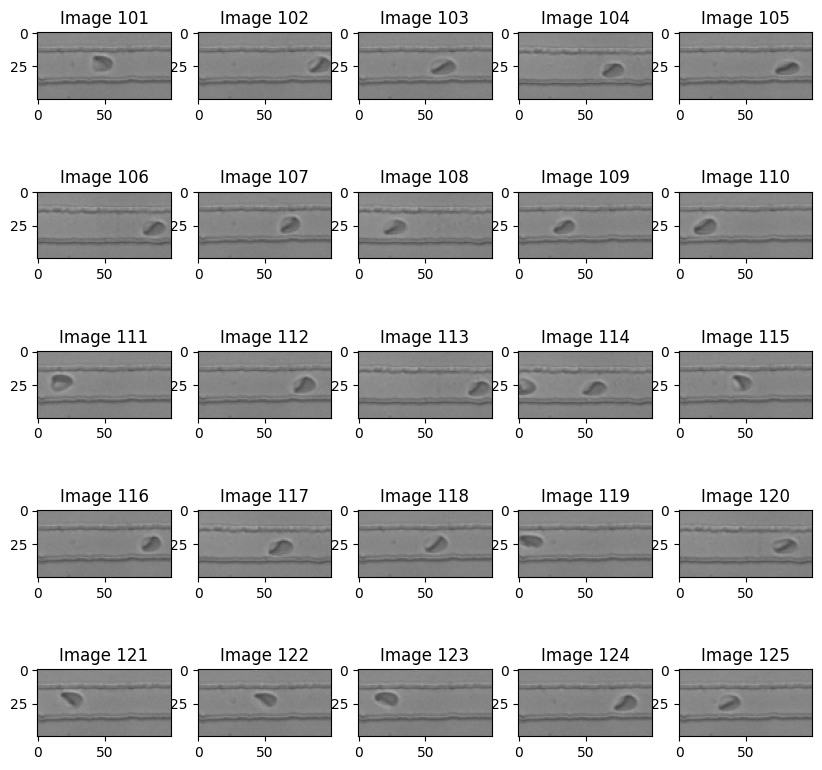

In [ ]:
# Show a range of images
img=100
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i+img])
  plt.title(f'Image {i+img+1}')
plt.show()

In [ ]:
# Detect bounding boxes
model = YOLO("best_e100.pt")
all_bboxes = detect_images(images, model)


0: 128x224 1 cell, 13.3ms
Speed: 0.7ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 8.7ms
Speed: 0.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 9.3ms
Speed: 0.9ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 9.3ms
Speed: 1.2ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 9.2ms
Speed: 0.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 2 cells, 9.6ms
Speed: 0.8ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 cell, 9

[[tensor([[131.7142,  53.6762,  53.3322,  36.7100]], device='cuda:0')],
 [tensor([[23.9654, 46.8648, 47.9307, 39.8120]], device='cuda:0')],
 [tensor([[35.7229, 54.3368, 56.0833, 39.0007]], device='cuda:0')],
 [tensor([[64.2280, 46.9875, 52.1931, 38.8458]], device='cuda:0')],
 [tensor([[46.4192, 47.9545, 54.4776, 40.1439]], device='cuda:0')],
 [tensor([[160.5193,  45.2572,  52.4106,  38.1180]], device='cuda:0')],
 [tensor([[170.6559,  53.3151,  48.6814,  36.1529]], device='cuda:0')],
 [tensor([[185.7998,  51.5488,  28.2423,  42.9057],
          [125.5892,  48.4706,  57.3162,  38.1245]], device='cuda:0')],
 [tensor([[178.7355,  52.4450,  42.3201,  36.5403]], device='cuda:0')],
 [tensor([[33.4804, 50.2492, 56.4651, 44.2840]], device='cuda:0')],
 [tensor([[173.6261,  45.8222,  52.7478,  38.3264]], device='cuda:0')],
 [tensor([[159.0136,  46.2838,  52.5894,  39.2004],
          [ 86.6979,  53.3426,  55.6208,  36.0667]], device='cuda:0')],
 [tensor([[26.0665, 48.0199, 49.4615, 38.4868]], dev

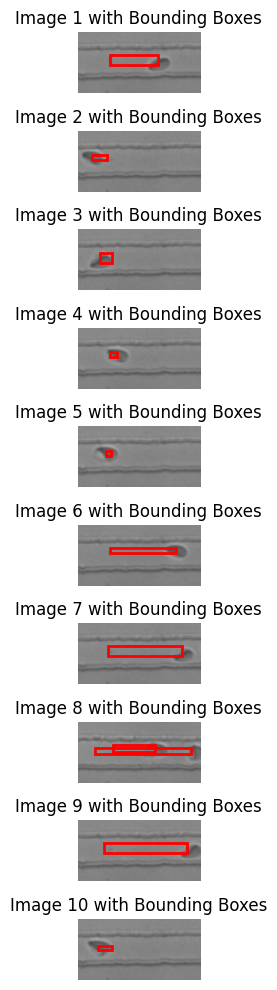

In [ ]:
# Visualize bbox
visualize_bboxes_on_images(images, all_bboxes, n_images=10)